In [18]:
"""
FH2  cutout + catalogue + PSF loader
Python 3.8  ‖  2025-07-18
"""
from pathlib import Path
from typing import Dict, Tuple, List, Sequence, Union

import matplotlib.pyplot as plt
from astropy.io import fits,ascii
import json
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import kernel_util, util
import time
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Analysis.image_reconstruction import MultiBandImageReconstruction as Reconstruction
import matplotlib.colors as colors 
import numpy as np
import galsim
import pandas as pd
from astropy.io import fits      # ⭐ 需要 astropy；NOIRLab Notebook 有预装

# ========= 0. 基础配置 =========
ROOT          = Path("/home/zizhao/jasmine-worksapce/FH2")
CATALOG_CSV   = ROOT / "fh2_desils_exploded_withID.csv"
IMG_DIR       = ROOT / "fitscutout"
PSF_DIR       = ROOT / "psfcoadd"          # 与 cutout 同一像素标尺
ROUND_DIGITS  = 5                          # 文件名保留位数
DEFAULT_PIXSCALE = 0.262                  # ″/pix，Legacy LS-DR9 cutout 默认值

# ========= 1. 帮助函数 =========
def build_cutout_name(ra: float, dec: float) -> str:
    """拼接 cutout 文件名。"""
    return f"ra_{ra:.{ROUND_DIGITS}f}_dec_{dec:.{ROUND_DIGITS}f}-subimage.fits"

def build_psf_name(ra: float, dec: float) -> str:
    """
    ★ 若 PSF cutout 文件与你的图像命名方式一致，可直接共用。
    否则在此改写成实际模式。
    """
    return f"ra_{ra:.{ROUND_DIGITS}f}_dec_{dec:.{ROUND_DIGITS}f}.fits"

def load_grz_layers(fits_path: Path) -> Dict[str, np.ndarray]:
    """
    读取 g/r/z 及各自 ivar。
    若 ivar 缺失则返回 None，便于后续判定。
    """
    with fits.open(fits_path) as hdul:
        data_ext = [h.data.astype(float) for h in hdul[1:]]   # 忽略 primary
    nlayer = len(data_ext)
    order6 = ["g", "g_ivar", "r", "r_ivar", "z", "z_ivar"]
    order8 = ["g", "g_ivar", "r", "r_ivar", "i", "i_ivar", "z", "z_ivar"]
    mapping = order6 if nlayer == 6 else order8 if nlayer == 8 else None
    if mapping is None:
        raise RuntimeError(f"{fits_path} 层数={nlayer} 不在 6/8 之中")

    layer_dict = {k: arr for k, arr in zip(mapping, data_ext) if k[0] in "grz"}
    # 确保 grz 键都在
    for band in "grz":
        layer_dict.setdefault(band,      None)
        layer_dict.setdefault(f"{band}_ivar", None)
    return layer_dict

def fallback_world2pix(ra_deg, dec_deg, img_shape, ra_c, dec_c, pixscale_arcsec=DEFAULT_PIXSCALE):
    """
    无 WCS fallback：小视场近似 TAN；x方向考虑 cos(dec)。
    返回 0-based pixel 坐标；origin='lower'。
    """
    ny, nx = img_shape
    deg_per_pix_y = pixscale_arcsec / 3600.0
    deg_per_pix_x = deg_per_pix_y / np.cos(np.deg2rad(dec_c))
    x0 = (nx - 1) / 2.0
    y0 = (ny - 1) / 2.0
    ra_arr  = np.asarray(ra_deg)
    dec_arr = np.asarray(dec_deg)
    x = x0 + (ra_arr - ra_c) / deg_per_pix_x
    y = y0 + (dec_arr - dec_c) / deg_per_pix_y
    return x, y

def RaDec2XY(ra_arr, dec_arr, ra_c, dec_c):
    pixel_decals=0.262
    image_size = 21
    image      = galsim.Image(image_size, image_size)
    cen_coord  = galsim.CelestialCoord(ra_c * galsim.degrees, dec_c * galsim.degrees)
    affine_wcs = galsim.PixelScale(pixel_decals).affine().shiftOrigin(image.center)
    wcs        = galsim.TanWCS(affine_wcs, world_origin=cen_coord)
    image.wcs  = wcs
    x_mbr_arr  = np.array([])
    y_mbr_arr  = np.array([])

    for ra, dec in zip(ra_arr, dec_arr):
        coord      = galsim.CelestialCoord(ra*galsim.degrees, dec*galsim.degrees)
        image_pos  = wcs.toImage(coord)
        x_mbr_arr  = np.append(x_mbr_arr, image_pos.x)
        y_mbr_arr  = np.append(y_mbr_arr, image_pos.y)
        
    return (x_mbr_arr, y_mbr_arr)

def take_first_two_rows(df: pd.DataFrame) -> pd.DataFrame:
    """ID=1-3 取前两行，其余保持原样。"""
    return df.sort_values("ID").head(2)


In [13]:
def crop_center_21(arr: np.ndarray) -> np.ndarray:
    """
    将任意尺寸的矩阵/图像裁剪为中心 21×21 区域。

    Parameters
    ----------
    arr : np.ndarray
        输入数组，至少 2 维。前两维表示 (H, W)。

    Returns
    -------
    np.ndarray
        裁剪后的数组，尺寸为 (21, 21, …)。
    """
    if arr.ndim < 2:
        raise ValueError("输入至少应为 2 维矩阵")

    H, W = arr.shape[-2], arr.shape[-1]
    if H < 21 or W < 21:
        raise ValueError(f"输入尺寸 ({H}, {W}) 过小，无法裁剪 21×21")

    half = 10                       # 21 的半径
    cy, cx = H // 2, W // 2         # 中心坐标（向下取整）
    y1, y2 = cy - half, cy + half + 1  # [cy-10, cy+10] 共 21 个像素
    x1, x2 = cx - half, cx + half + 1

    # 先针对最后两维裁剪，其余维度保持不变
    return arr[..., y1:y2, x1:x2] if arr.ndim > 2 else arr[y1:y2, x1:x2]

In [19]:
cat = pd.read_csv(CATALOG_CSV)
grouped = cat.groupby(["ra", "dec"], sort=False)
for (ra_c, dec_c), grp in grouped:
    

        sub = take_first_two_rows(grp)
        cutout_path = IMG_DIR / build_cutout_name(ra_c, dec_c)
        psf_path    = PSF_DIR / build_psf_name(ra_c, dec_c)  # ← 若命名不同请改

        # ---------- 读 cutout ----------
        try:
            layers = load_grz_layers(cutout_path)
        except Exception as e:
            print(f"[WARN] 跳过 {cutout_path.name}: {e}")
            continue
        
        shape = layers["g"].shape if layers["g"] is not None else next(x.shape for x in layers.values() if x is not None)
        
        print(sub["ra_out"])
        print(sub["dec_out"])
        # ---------- 坐标转换 ----------
        # x_pix, y_pix = fallback_world2pix(
        #     sub["ra_out"].values, sub["dec_out"].values,
        #     img_shape=shape, ra_c=ra_c, dec_c=dec_c
        # )
        x_pix, y_pix = RaDec2XY(sub["ra_out"].values, sub["dec_out"].values, ra_c ,dec_c)
        
        # ---------- 读 PSF ----------

        if psf_path.exists():
            with fits.open(psf_path) as hdul:
                
                if len(hdul)==3:
                    psf_g = hdul[0].data.astype(float)
                    psf_r = hdul[1].data.astype(float)
                    psf_z = hdul[2].data.astype(float)
                    
                elif len(hdul)==4:
                    
                    psf_g = hdul[0].data.astype(float)
                    psf_r = hdul[1].data.astype(float)
                    psf_z = hdul[3].data.astype(float)
                else:
                    assert False, "PSF file wrong"
                    
                psf_g=crop_center_21(psf_g)
                psf_r=crop_center_21(psf_r)
                psf_z=crop_center_21(psf_z)
                    
        # ---------- 准备输入 ----------
        data_g=layers["g"]
        data_r=layers["r"]
        data_z=layers["z"]
        ivar_g=layers["g_ivar"]
        ivar_r=layers["r_ivar"]
        ivar_z=layers["z_ivar"]
        psf_g=np.abs(psf_g);psf_g=(psf_g/psf_g.sum())
        psf_r=np.abs(psf_r);psf_r=(psf_r/psf_r.sum())
        psf_z=np.abs(psf_z);psf_z=(psf_z/psf_z.sum())
        
        
        rms_map_g = np.zeros_like(ivar_g);positive = ivar_g > 0;rms_map_g[positive] = 1 / np.sqrt(ivar_g[positive])
        rms_map_r = np.zeros_like(ivar_r);positive = ivar_r > 0;rms_map_r[positive] = 1 / np.sqrt(ivar_r[positive])
        rms_map_z = np.zeros_like(ivar_z);positive = ivar_z > 0;rms_map_z[positive] = 1 / np.sqrt(ivar_z[positive])
        
        if ra_c == 272.303124:
            print("STOP")
            break
        
        #-----------Lenstronomy--------
        # Lenstronomy_model(data_g,data_r,data_z,rms_map_g,rms_map_r,rms_map_z)

0    179.093347
1    179.093882
Name: ra_out, dtype: float64
0    21.987776
1    21.987996
Name: dec_out, dtype: float64
3    244.705929
4    244.706237
Name: ra_out, dtype: float64
3    6.476708
4    6.476812
Name: dec_out, dtype: float64
5    100.652815
6    100.653166
Name: ra_out, dtype: float64
5    56.28647
6    56.28632
Name: dec_out, dtype: float64
[WARN] 跳过 ra_4.94658_dec_1.50098-subimage.fits: /home/zizhao/jasmine-worksapce/FH2/fitscutout/ra_4.94658_dec_1.50098-subimage.fits 层数=16 不在 6/8 之中
10    65.581240
11    65.580991
Name: ra_out, dtype: float64
10   -4.797413
11   -4.797341
Name: dec_out, dtype: float64
13    9.315902
14    9.316204
Name: ra_out, dtype: float64
13    20.973792
14    20.973772
Name: dec_out, dtype: float64
[WARN] 跳过 ra_234.25436_dec_32.39078-subimage.fits: /home/zizhao/jasmine-worksapce/FH2/fitscutout/ra_234.25436_dec_32.39078-subimage.fits 层数=12 不在 6/8 之中
17    246.258188
18    246.258290
Name: ra_out, dtype: float64
17    43.15886
18    43.15872
Name: 

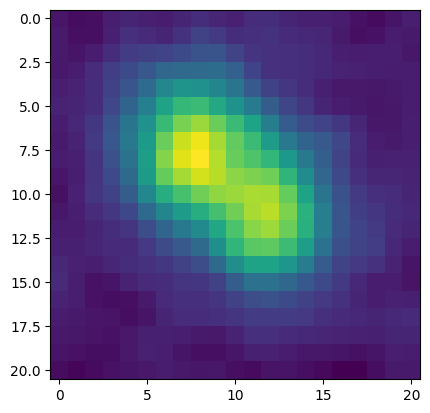

In [20]:
plt.imshow(data_g)

In [ ]:
# def Lenstronomy_model(data_g,data_r,data_z,rms_map_g,rms_map_r,rms_map_z):
cutout_g=data_g[0:5,0:5]
rms_g=np.std(cutout_g)
cutout_r=data_r[0:5,0:5]
rms_r=np.std(cutout_r)
cutout_z=data_z[0:5,0:5]
rms_z=np.std(cutout_z)
    
deltaPix_g=0.262
numPix_g=data_g.shape[0]
psf_type_g='PIXEL'

_, _, ra_at_xy_0_g, dec_at_xy_0_g, _, _, Mpix2coord_g, _ = util.make_grid_with_coordtransform(numPix=numPix_g, deltapix=deltaPix_g, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data_g = {'background_rms': rms_g,  # rms of background noise
            'exposure_time': 600,  # exposure time (or a map per pixel)
            'ra_at_xy_0': ra_at_xy_0_g,  # RA at (0,0) pixel
            'dec_at_xy_0': dec_at_xy_0_g,  # DEC at (0,0) pixel 
            'transform_pix2angle': Mpix2coord_g,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
            'image_data': data_g,  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
            }


kwargs_psf_g={'psf_type': psf_type_g, 'kernel_point_source': psf_g, 'pixel_size': deltaPix_g}


kwargs_numerics_g = {'supersampling_factor': 4, 'supersampling_convolution': False}


#r_data_set
deltaPix_r=0.262
numPix_r=data_r.shape[0]
psf_type_r='PIXEL'

_, _, ra_at_xy_0_r, dec_at_xy_0_r, _, _, Mpix2coord_r, _ = util.make_grid_with_coordtransform(numPix=numPix_r, deltapix=deltaPix_r, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data_r = {'background_rms': rms_r,  # rms of background noise
            'exposure_time': 600,  # exposure time (or a map per pixel)
            'ra_at_xy_0': ra_at_xy_0_r,  # RA at (0,0) pixel
            'dec_at_xy_0': dec_at_xy_0_r,  # DEC at (0,0) pixel 
            'transform_pix2angle': Mpix2coord_r,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
            'image_data': data_r,  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
            }


kwargs_psf_r={'psf_type': psf_type_r, 'kernel_point_source': psf_r, 'pixel_size': deltaPix_r}


kwargs_numerics_r = {'supersampling_factor': 4, 'supersampling_convolution': False}

#z_data_set
deltaPix_z=0.262
numPix_z=data_z.shape[0]
psf_type_z='PIXEL'

_, _, ra_at_xy_0_z, dec_at_xy_0_z, _, _, Mpix2coord_z, _ = util.make_grid_with_coordtransform(numPix=numPix_z, deltapix=deltaPix_z, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data_z = {'background_rms': rms_z,  # rms of background noise
            'exposure_time': 600,  # exposure time (or a map per pixel)
            'ra_at_xy_0': ra_at_xy_0_z,  # RA at (0,0) pixel
            'dec_at_xy_0': dec_at_xy_0_z,  # DEC at (0,0) pixel 
            'transform_pix2angle': Mpix2coord_z,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
            'image_data': data_z,  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
            }

kwargs_psf_z={'psf_type': psf_type_z, 'kernel_point_source': psf_z, 'pixel_size': deltaPix_z}

kwargs_numerics_z = {'supersampling_factor': 4, 'supersampling_convolution': False}

#multi_band_data
multi_band_list = [[kwargs_data_g, kwargs_psf_g, kwargs_numerics_g],[kwargs_data_r, kwargs_psf_r, kwargs_numerics_r],[kwargs_data_z, kwargs_psf_z, kwargs_numerics_z]]

#multi_band_joint
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear' }

#kwargs_model
lens_light_model_list = ['SERSIC_ELLIPSE']*3
point_source_list = ['UNLENSED'] 

#index_model_list
index_lens_light_model_list = [[0],[1],[2]]
index_point_source_model_list = [[0], [0], [0]] 

kwargs_model = dict(
    lens_light_model_list = lens_light_model_list,
    point_source_model_list = point_source_list,
    index_lens_light_model_list = index_lens_light_model_list,
    index_point_source_model_list = index_point_source_model_list,
)

#kwargs_likelihood
kwargs_likelihood = {'check_bounds': True, 'source_marg': False,'bands_compute': [True,True,True], 'check_positive_flux':True}

#kwargs_lens_light_params
kwargs_fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

x1=(x_pix[0]-10)*0.262
x2=(x_pix[1]-10)*0.262
y1=(y_pix[0]-10)*0.262
y2=(y_pix[1]-10)*0.262

xcen=(x1+x2)/2
ycen=(y1+y2)/2

#add g lens_light
kwargs_fixed_lens_light.append({'n_sersic':4})
kwargs_lens_light_init.append({'R_sersic': 0.7*0.262, 'e1': 0.01, 'e2': 0.01, 'center_x': xcen, 'center_y': ycen})
kwargs_lens_light_sigma.append({ 'R_sersic': 0.01,'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens_light.append({'R_sersic': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': xcen-3.0*0.262, 'center_y':ycen-3.0*0.262})
kwargs_upper_lens_light.append({'R_sersic': 2*0.262,'e1': 0.5, 'e2': 0.5, 'center_x':  xcen+3.0*0.262, 'center_y': ycen+3.0*0.262})

#add r lens_light
kwargs_fixed_lens_light.append({'n_sersic':4})
kwargs_lens_light_init.append({'R_sersic': 0.7*0.262, 'e1': 0.01, 'e2': 0.01, 'center_x': xcen, 'center_y': ycen})
kwargs_lens_light_sigma.append({ 'R_sersic': 0.01,'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens_light.append({'R_sersic': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': xcen-3.0*0.262, 'center_y': ycen-3.0*0.262})
kwargs_upper_lens_light.append({'R_sersic': 2*0.262,'e1': 0.5, 'e2': 0.5, 'center_x': xcen+3.0*0.262, 'center_y': ycen+3.0*0.262})

#add z lens_light
kwargs_fixed_lens_light.append({'n_sersic':4})
kwargs_lens_light_init.append({'R_sersic': 0.7*0.262, 'e1': 0.01, 'e2': 0.01, 'center_x': xcen, 'center_y': ycen})
kwargs_lens_light_sigma.append({ 'R_sersic': 0.01,'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens_light.append({'R_sersic': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': xcen-3.0*0.262, 'center_y':  ycen-3.0*0.262})
kwargs_upper_lens_light.append({'R_sersic': 2*0.262,'e1': 0.5, 'e2': 0.5, 'center_x': xcen+3.0*0.262, 'center_y': ycen+3.0*0.262})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_fixed_lens_light, kwargs_lower_lens_light, 
                kwargs_upper_lens_light]

#add point
kwargs_fixed_ps = []
kwargs_ps_init = []
kwargs_ps_sigma = []
kwargs_lower_ps = []
kwargs_upper_ps = []


kwargs_ps_init  = [{'ra_image':[x1,x2], 'dec_image':[y1,y2]}]  # 2 个像
kwargs_ps_sigma = [{'ra_image':[0.02]*2, 'dec_image':[0.02]*2}]
kwargs_fixed_ps = [{}]          # 不固定振幅；线性求解器会加 point_amp
kwargs_lower_ps = [{'ra_image':[x1-0.262,x2-0.262], 'dec_image':[y1-0.262,y2-0.262]}]
kwargs_upper_ps = [{'ra_image':[x1+0.262,x2+0.262], 'dec_image':[y1+0.262,y2+0.262]}]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {
            'lens_light_model': lens_light_params,
            'point_source_model': ps_params}

kwargs_constraints = {
                'joint_lens_light_with_lens_light':[[0, 1, ['center_x', 'center_y']],[0,2,['center_x', 'center_y']]],
                'num_point_source_list': [2]}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

threadcount=100
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100, 'threadCount': threadcount}], 
                       ['MCMC', {'n_burn': 50, 'n_run': 50, 'walkerRatio': 10,'sigma_scale': .1,'threadCount': threadcount}]]

# fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 300, 'n_iterations': 300, 'threadCount': threadcount}], 
#                        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0550737252934395 reduced X^2 of best position
-685.270384578089 log likelihood
1299.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.5233962133319671, 'n_sersic': 4, 'e1': -0.3240337964266255, 'e2': 0.02568217566335331, 'center_x': 0.13254796492079185, 'center_y': -0.2179892836695898}, {'amp': 1, 'R_sersic': 0.5239455538220734, 'n_sersic': 4, 'e1': -0.35212803598946524, 'e2': 0.3497192788883267, 'center_x': 0.13254796492079185, 'center_y': -0.2179892836695898}, {'amp': 1, 'R_sersic': 0.17211932644404418, 'n_sersic': 4, 'e1': -0.14461371389280644, 'e2': 0.07986829347281862, 'center_x': 0.13254796492079185, 'center_y': -0.2179892836695898}] lens light result
[{'ra_image': array([ 0.66916748, -0.82028434]), 'dec_image': array([ 0.68138528, -0.69977801]), 'point_amp': array([1., 1.])}] point source result
{} special param result
144.59351301193237 time used fo

100%|██████████| 100/100 [03:17<00:00,  1.97s/it]

Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  50
Sampling iterations (in current run): 100
199.0038857460022 time taken for MCMC sampling


In [68]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="viridis",)
                    
print(kwargs_result)

-1.0336624478116976 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7203702531905866
reduced chi^2 of data  1 =  1.348802392371999
reduced chi^2 of data  2 =  1.031814697872508
{'kwargs_lens': [], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 0.5695601301388258, 'R_sersic': 0.5231824791851728, 'n_sersic': 4, 'e1': -0.3406499500701129, 'e2': 0.059330216005303235, 'center_x': 0.1327261422771705, 'center_y': -0.2233974057242174}, {'amp': 1.0356244758588269, 'R_sersic': 0.5238900392704996, 'n_sersic': 4, 'e1': -0.3366700751036811, 'e2': 0.34803703916745704, 'center_x': 0.1327261422771705, 'center_y': -0.2233974057242174}, {'amp': 13.932440194840527, 'R_sersic': 0.16751847457952404, 'n_sersic': 4, 'e1': -0.14986139754722105, 'e2': 0.07514765760329543, 'center_x': 0.1327261422771705, 'center_y': -0.2233974057242174}], 'kwargs_ps': [{'ra_image': array([ 0.67064287, -0.8202687 ]), 'dec_image': array([ 0.6690365 , -0

In [69]:
# save g fits                  
numPix_s=21
deltaPix_s=0.1

model_data_g=modelPlot.saving_fits_files(numPix_s,deltaPix_s,band_index=0)

model_g=model_data_g[0]
source_g= model_data_g[1]
lens_g= model_data_g[2]
image_g= model_data_g[3]
norm_res_g=model_data_g[4]

fname_f='./results/g_modeling.fits'

hdu_primary = fits.PrimaryHDU()
data_f=fits.ImageHDU(data_g,name='data')
model_f=fits.ImageHDU(model_g,name='model')
lens_f=fits.ImageHDU(lens_g,name='lens')
image_f=fits.ImageHDU(image_g,name='image')
source_f=fits.ImageHDU(source_g,name='source')
norm_res_f=fits.ImageHDU(norm_res_g,name='normalized residuals')
hdu_f=fits.HDUList([hdu_primary,data_f,model_f,lens_f,image_f,source_f,norm_res_f])

hdu_f.writeto(fname_f, overwrite=True)

# save r fits
model_data_r=modelPlot.saving_fits_files(numPix_s,deltaPix_s,band_index=1)

model_r=model_data_r[0]
source_r= model_data_r[1]
lens_r= model_data_r[2]
image_r= model_data_r[3]
norm_res_r=model_data_r[4]


fname_f='./results/r_modeling.fits'

hdu_primary = fits.PrimaryHDU()
data_f=fits.ImageHDU(data_r,name='data')
model_f=fits.ImageHDU(model_r,name='model')
lens_f=fits.ImageHDU(lens_r,name='lens')
image_f=fits.ImageHDU(image_r,name='image')
source_f=fits.ImageHDU(source_r,name='source')
norm_res_f=fits.ImageHDU(norm_res_r,name='normalized residuals')
hdu_f=fits.HDUList([hdu_primary,data_f,model_f,lens_f,image_f,source_f,norm_res_f])

hdu_f.writeto(fname_f, overwrite=True)

# save z fits
model_data_z=modelPlot.saving_fits_files(numPix_s,deltaPix_s,band_index=2)

model_z=model_data_z[0]
source_z= model_data_z[1]
lens_z= model_data_z[2]
image_z= model_data_z[3]
norm_res_z=model_data_z[4]

fname_f='./results/z_modeling.fits'

hdu_primary = fits.PrimaryHDU()
data_f=fits.ImageHDU(data_z,name='data')
model_f=fits.ImageHDU(model_z,name='model')
lens_f=fits.ImageHDU(lens_z,name='lens')
image_f=fits.ImageHDU(image_z,name='image')
source_f=fits.ImageHDU(source_z,name='source')
norm_res_f=fits.ImageHDU(norm_res_z,name='normalized residuals')
hdu_f=fits.HDUList([hdu_primary,data_f,model_f,lens_f,image_f,source_f,norm_res_f])

hdu_f.writeto(fname_f, overwrite=True)


#save chain
# sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]

# np.savetxt('./results/samples_mcmc.txt',samples_mcmc)
# np.savetxt('./results/dist_mcmc.txt',dist_mcmc)

# with open('./results/param_mcmc.json','w') as f:
#     json.dump(param_mcmc,f)

#转化结果中的array以确保能够保存json文件
def numpy_to_dict(d):  
    """Recursively convert numpy arrays to lists in a dict."""  
    if isinstance(d, np.ndarray):  
        return d.tolist()  
    elif isinstance(d, dict):  
        return {k: numpy_to_dict(v) for k, v in d.items()}  
    elif isinstance(d, list):  
        return [numpy_to_dict(v) for v in d]  
    else:  
        return d 

# 转换 NumPy 数组  
kwargs_result = numpy_to_dict(kwargs_result) 
with open('./results/kwargs_result.json','w') as f:
    json.dump(kwargs_result,f)
    



== g-band HDUs ==
             DATA shape=(21, 21) min=-0.00361 max=0.0739
            MODEL shape=(21, 21) min=0.00011 max=0.0943
             LENS shape=(21, 21) min=0.00011 max=0.0763
            IMAGE shape=(21, 21) min=0 max=0
           SOURCE shape=(21, 21) min=0 max=0
  NORMALIZED RESIDUALS shape=(21, 21) min=-2.7 max=2.24

== r-band HDUs ==
             DATA shape=(21, 21) min=-0.00804 max=0.147
            MODEL shape=(21, 21) min=6.53e-05 max=0.186
             LENS shape=(21, 21) min=6.53e-05 max=0.171
            IMAGE shape=(21, 21) min=0 max=0
           SOURCE shape=(21, 21) min=0 max=0
  NORMALIZED RESIDUALS shape=(21, 21) min=-3.72 max=2.99

== z-band HDUs ==
             DATA shape=(21, 21) min=-0.0456 max=0.275
            MODEL shape=(21, 21) min=9.87e-05 max=0.261
             LENS shape=(21, 21) min=9.87e-05 max=0.23
            IMAGE shape=(21, 21) min=0 max=0
           SOURCE shape=(21, 21) min=0 max=0
  NORMALIZED RESIDUALS shape=(21, 21) min=-3.21 max=2.74


[INFO] 保存: results/g_6panels_bwr.png


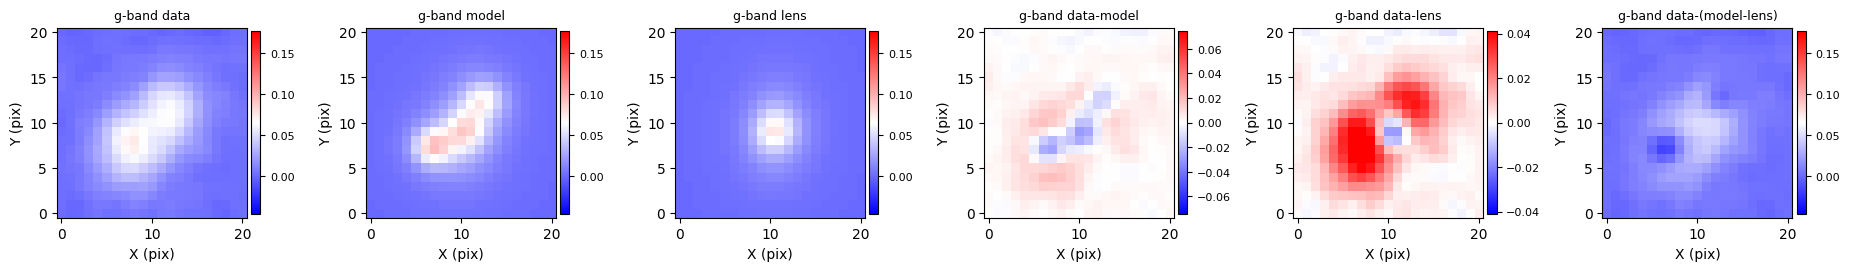

[INFO] 保存: results/r_6panels_bwr.png


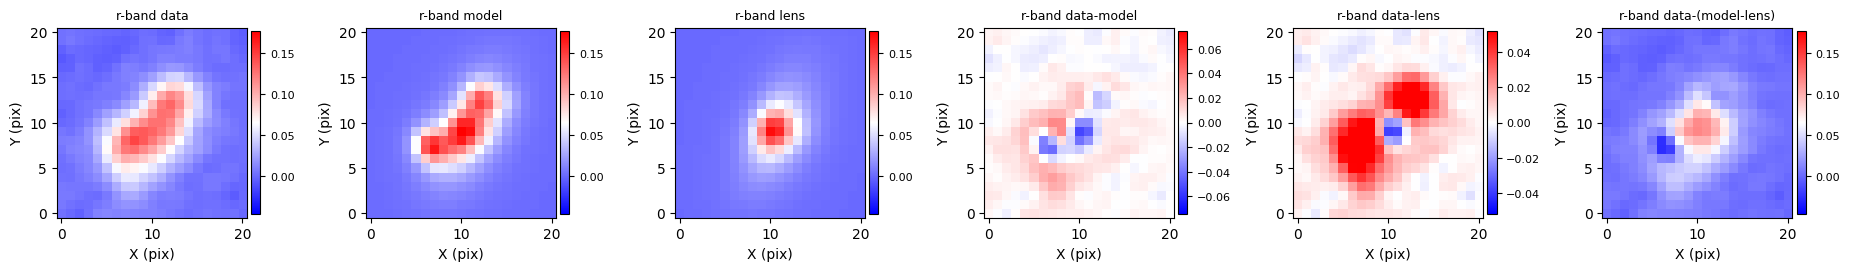

[INFO] 保存: results/z_6panels_bwr.png


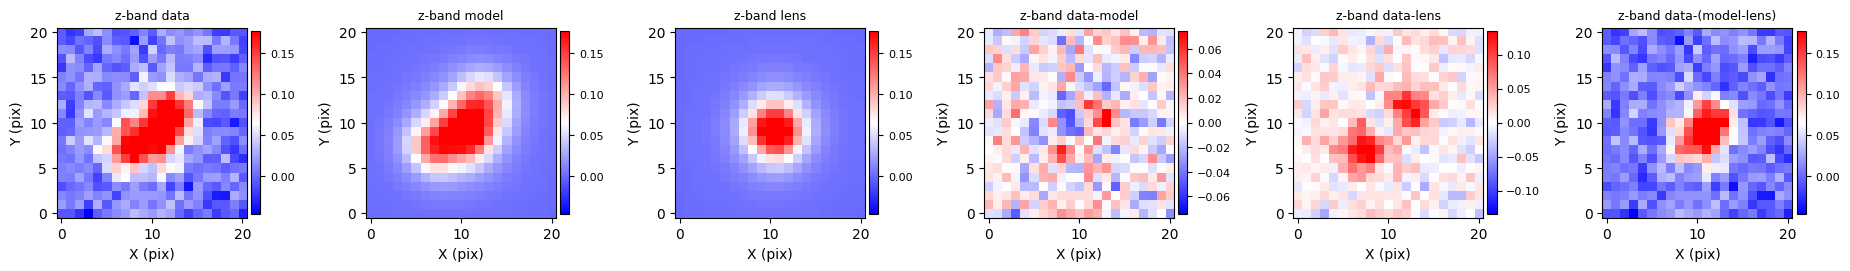

In [70]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import (ZScaleInterval, AsinhStretch, ImageNormalize)

# ===================== 配置区域 =====================
bands = ["g", "r", "z"]                # 需要处理的波段
results_dir = Path("./results")        # FITS 文件目录
save_fig = True                        # 是否保存单波段面板图
fig_dpi = 180
stretch_kind = "linear"                 # 'asinh' 或 'linear'
print_hdus = True                      # 打印每个文件的 2D HDU 列表
lens_use_data_model_norm = True        # lens 面板是否使用 data/model 的统一色标
bwr_cmap = "bwr"                       # 全部面板使用的 colormap
manual_map = {}                        # 手动指定扩展名（例见上方说明）

# ===================== 工具函数 =====================
def find_band_file(band):
    for name in (f"{band}_modelling.fits", f"{band}_modeling.fits"):
        p = results_dir / name
        if p.is_file():
            return p
    raise FileNotFoundError(f"{band}: 未找到 {band}_modelling.fits / {band}_modeling.fits")

def list_2d_arrays(hdul):
    out = {}
    for i, hdu in enumerate(hdul):
        data = getattr(hdu, "data", None)
        if data is None or not hasattr(data, "ndim"):
            continue
        if data.ndim == 2:
            name = hdu.name.strip() if hdu.name else f"EXT{i}"
            out[name.upper()] = np.array(data, dtype=float)
    return out

def guess_component(arr_dict):
    keys = list(arr_dict.keys())
    def pick(cands, exclude=None):
        exclude = exclude or []
        for k in keys:
            if any(c in k for c in cands) and not any(ex in k for ex in exclude):
                return k
        return None
    return dict(
        data   = pick(["DATA","IMAGE","OBS"], exclude=["MODEL"]),
        model  = pick(["MODEL_IMAGE","MODELIMG","MODEL"]),
        lens   = pick(["LENS_LIGHT","LENS","GAL"], exclude=["SOURCE"]),
        source = pick(["SOURCE_LIGHT","SOURCE"]),
        ps     = pick(["POINT","PS","AGN"])
    )

def build_lens(arr_dict, comp):
    # 如果已经有 lens 扩展
    if comp.get("lens") and comp["lens"] in arr_dict:
        return arr_dict[comp["lens"]]
    # 用 model - source - point_source 构造
    if all(comp.get(k) and comp[k] in arr_dict for k in ("model","source")):
        model = arr_dict[comp["model"]]
        source = arr_dict[comp["source"]]
        ps = arr_dict[comp["ps"]] if comp.get("ps") and comp["ps"] in arr_dict else 0.0
        return model - source - ps
    return None

def try_wcs(hdul):
    for h in hdul:
        hdr = getattr(h, "header", None)
        if hdr and "CTYPE1" in hdr and "CTYPE2" in hdr:
            try:
                w = WCS(hdr)
                if w.naxis >= 2:
                    return w
            except Exception:
                pass
    return None

def make_norm(data, kind="asinh", sym=False):
    finite = np.isfinite(data)
    if not finite.any():
        vmin, vmax = 0.0, 1.0
    else:
        zs = ZScaleInterval()
        vmin, vmax = zs.get_limits(data[finite])
    if sym:
        m = max(abs(vmin), abs(vmax))
        vmin, vmax = -m, m
    if kind == "asinh":
        return ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
    else:
        from astropy.visualization import MinMaxInterval
        return ImageNormalize(vmin=vmin, vmax=vmax)

def compute_global_limits(images_list):
    zs = ZScaleInterval()
    low_high = []
    for img in images_list:
        finite = np.isfinite(img)
        if finite.any():
            lo, hi = zs.get_limits(img[finite])
            low_high.append((lo, hi))
    if not low_high:
        return 0.0, 1.0
    vmin = min(v[0] for v in low_high)
    vmax = max(v[1] for v in low_high)
    return vmin, vmax

def norm_from_limits(vmin, vmax, kind="asinh", sym=False):
    if sym:
        m = max(abs(vmin), abs(vmax))
        vmin, vmax = -m, m
    if kind == "asinh":
        return ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
    else:
        from astropy.visualization import MinMaxInterval
        return ImageNormalize(vmin=vmin, vmax=vmax)

# ===================== 预读取所有波段 (构建 band_data) =====================
band_data = {}
for b in bands:
    fpath = find_band_file(b)
    with fits.open(fpath) as hdul:
        arr_dict = list_2d_arrays(hdul)
        if print_hdus:
            print(f"\n== {b}-band HDUs ==")
            for name, arr in arr_dict.items():
                print("  {0:>15s} shape={1} min={2:.3g} max={3:.3g}".format(
                    name, arr.shape, np.nanmin(arr), np.nanmax(arr)))
        comp = guess_component(arr_dict)
        if b in manual_map:
            for role, ext in manual_map[b].items():
                comp[role] = ext if isinstance(ext, str) else list(arr_dict.keys())[ext]

        if comp["data"] not in arr_dict:
            raise RuntimeError(f"{b}: 未识别 data (comp={comp})，请在 manual_map 指定。")
        if comp["model"] not in arr_dict:
            raise RuntimeError(f"{b}: 未识别 model (comp={comp})，请在 manual_map 指定。")

        data = arr_dict[comp["data"]]
        model = arr_dict[comp["model"]]
        lens = build_lens(arr_dict, comp)
        if lens is None:
            print(f"[警告] {b}: 未能构建 lens，使用 NaN")
            lens = np.full_like(data, np.nan)

        residual = data - model
        datalens = data - lens
        model_minus_lens = model - lens
        data_minus_model_minus_lens = data - model_minus_lens  # = data - (model - lens) = residual + lens
        wcs = try_wcs(hdul)

    band_data[b] = dict(
        data=data,
        model=model,
        lens=lens,
        residual=residual,
        datalens=datalens,
        model_minus_lens=model_minus_lens,
        data_minus_model_minus_lens=data_minus_model_minus_lens,
        wcs=wcs
    )

# ========== 统一色标范围 ==========
# 1) data/model/lens/data-(model-lens) 共用
collect_positive_like = []
for b in bands:
    bd = band_data[b]
    collect_positive_like.extend([
        bd["data"], bd["model"], bd["lens"], bd["data_minus_model_minus_lens"]
    ])
global_vmin, global_vmax = compute_global_limits(collect_positive_like)

# 2) residual 全局对称
all_residuals = [band_data[b]["residual"] for b in bands]
res_vmin, res_vmax = compute_global_limits(all_residuals)
res_m = max(abs(res_vmin), abs(res_vmax))
res_vmin_sym, res_vmax_sym = -res_m, res_m

# ===================== 单波段 6 面板绘图函数 =====================
def plot_band(band):
    d = band_data[band]
    panels = [
        ("data", d["data"], norm_from_limits(global_vmin, global_vmax, kind=stretch_kind)),
        ("model", d["model"], norm_from_limits(global_vmin, global_vmax, kind=stretch_kind)),
        ("lens", d["lens"],
            norm_from_limits(global_vmin, global_vmax, kind=stretch_kind) if lens_use_data_model_norm
            else make_norm(d["lens"], kind=stretch_kind)),
        ("data-model", d["residual"],
            norm_from_limits(res_vmin_sym, res_vmax_sym, kind=stretch_kind, sym=True)),
        ("data-lens", d["datalens"],
            make_norm(d["datalens"], kind=stretch_kind, sym=True)),
        ("data-(model-lens)", d["data_minus_model_minus_lens"],
            norm_from_limits(global_vmin, global_vmax, kind=stretch_kind))
        # 如果希望最后这个也用对称范围，把上一行改成 residual 的 norm
        # norm_from_limits(res_vmin_sym, res_vmax_sym, kind=stretch_kind, sym=True)
    ]

    ncols = len(panels)
    wcs = d["wcs"]
    fig, axes = plt.subplots(1, ncols, figsize=(3.1 * ncols, 4),
                             subplot_kw={'projection': wcs if wcs is not None else None})
    if ncols == 1:
        axes = [axes]

    for ax, (title, img, norm) in zip(axes, panels):
        if wcs is not None:
            ax.set_xlabel("RA")
            ax.set_ylabel("Dec")
        else:
            ax.set_xlabel("X (pix)")
            ax.set_ylabel("Y (pix)")
        im = ax.imshow(img, origin='lower', cmap=bwr_cmap, norm=norm)
        ax.set_title(f"{band}-band {title}", fontsize=9)
        ax.grid(False)
        cbar = plt.colorbar(im, ax=ax, fraction=0.045, pad=0.02)
        cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()
    if save_fig:
        out = results_dir / f"{band}_6panels_bwr.png"
        plt.savefig(out, dpi=fig_dpi)
        print(f"[INFO] 保存: {out}")
    plt.show()

# ========== 逐波段出图 ==========
for b in bands:
    plot_band(b)

# ===================== （可选）RGB 合成工具 =====================
try:
    from astropy.visualization import make_lupton_rgb as _lupton
    HAS_LUPTON = True
except Exception:
    HAS_LUPTON = False

def _simple_asinh_rgb(r, g, b, perc_lo=0.25, perc_hi=99.5, alpha=3.0):
    def prep(x):
        x = np.array(x, dtype=float)
        finite = np.isfinite(x)
        if not finite.any():
            return np.zeros_like(x)
        lo, hi = np.nanpercentile(x[finite], [perc_lo, perc_hi])
        if hi <= lo:
            hi = lo + 1e-12
        x = (x - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        return x
    rr = prep(r); gg = prep(g); bb = prep(b)
    stack = np.stack([rr, gg, bb], axis=-1)
    if alpha > 0:
        stack = np.arcsinh(alpha * stack) / np.arcsinh(alpha)
    return np.clip(stack, 0, 1)

def build_rgb_from_band_data(band_data,
                             component="data",
                             method="lupton",
                             Q=8, stretch=0.5, minimum=0.0,
                             perc_lo=0.25, perc_hi=99.5, alpha=3.0,
                             per_band_scale=None,
                             mask_negative=True):
    for b in ('g','r','z'):
        if b not in band_data:
            raise ValueError("缺少波段: " + b)
        if component not in band_data[b]:
            raise ValueError("波段 {0} 中不存在组件 {1}".format(b, component))
    g_img = np.array(band_data['g'][component], dtype=float)
    r_img = np.array(band_data['r'][component], dtype=float)
    z_img = np.array(band_data['z'][component], dtype=float)
    if per_band_scale:
        g_img *= per_band_scale.get('g', 1.0)
        r_img *= per_band_scale.get('r', 1.0)
        z_img *= per_band_scale.get('z', 1.0)
    if mask_negative:
        g_img = np.where(g_img > 0, g_img, 0)
        r_img = np.where(r_img > 0, r_img, 0)
        z_img = np.where(z_img > 0, z_img, 0)

    if method.lower() == "lupton" and HAS_LUPTON:
        rgb_uint8 = _lupton(z_img, r_img, g_img, Q=Q, stretch=stretch, minimum=minimum)
        rgb = (rgb_uint8 / 255.0).astype(float)
    elif method.lower() == "lupton" and not HAS_LUPTON:
        print("[INFO] 未找到 Lupton 函数，使用 asinh 回退")
        rgb = _simple_asinh_rgb(z_img, r_img, g_img, perc_lo=perc_lo, perc_hi=perc_hi, alpha=alpha)
    else:
        rgb = _simple_asinh_rgb(z_img, r_img, g_img, perc_lo=perc_lo, perc_hi=perc_hi, alpha=alpha)
    return rgb

def show_rgb_gallery(band_data,
                     components=('data','model','datalens','data_minus_model_minus_lens'),
                     method='lupton',
                     figsize=(4.2,4.2),
                     save_prefix=None,
                     **kwargs):
    n = len(components)
    fig, axes = plt.subplots(1, n, figsize=(figsize[0]*n, figsize[1]))
    if n == 1:
        axes = [axes]
    for ax, comp in zip(axes, components):
        try:
            rgb = build_rgb_from_band_data(band_data, component=comp, method=method, **kwargs)
            ax.imshow(rgb, origin='lower')
            ax.set_title(f"{comp} ({method})", fontsize=9)
        except Exception as e:
            ax.text(0.5, 0.5, str(e), ha='center', va='center', fontsize=8)
        ax.axis('off')
        if save_prefix:
            out = results_dir / f"{save_prefix}_{comp}_{method}.png"
            results_dir.mkdir(exist_ok=True, parents=True)
            plt.imsave(out, rgb)
    if save_prefix:
        print("[INFO] 彩图已保存前缀:", save_prefix)
    plt.tight_layout()
    plt.show()



[INFO] 彩图已保存前缀: grz_rgb


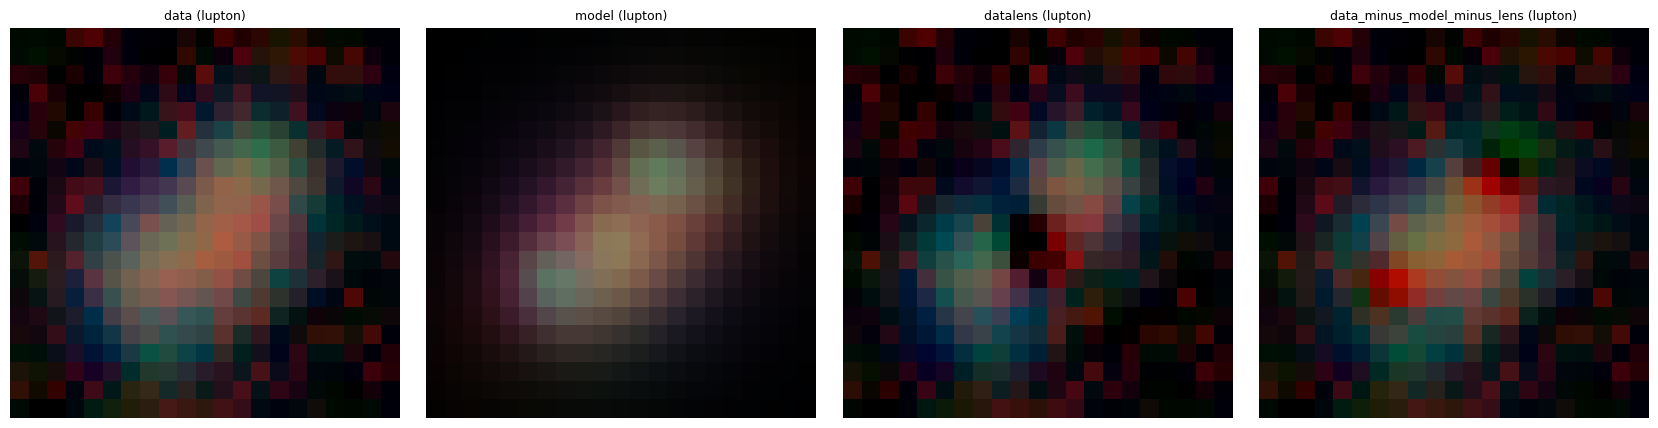

[INFO] 彩图已保存前缀: grz_rgb_asinh


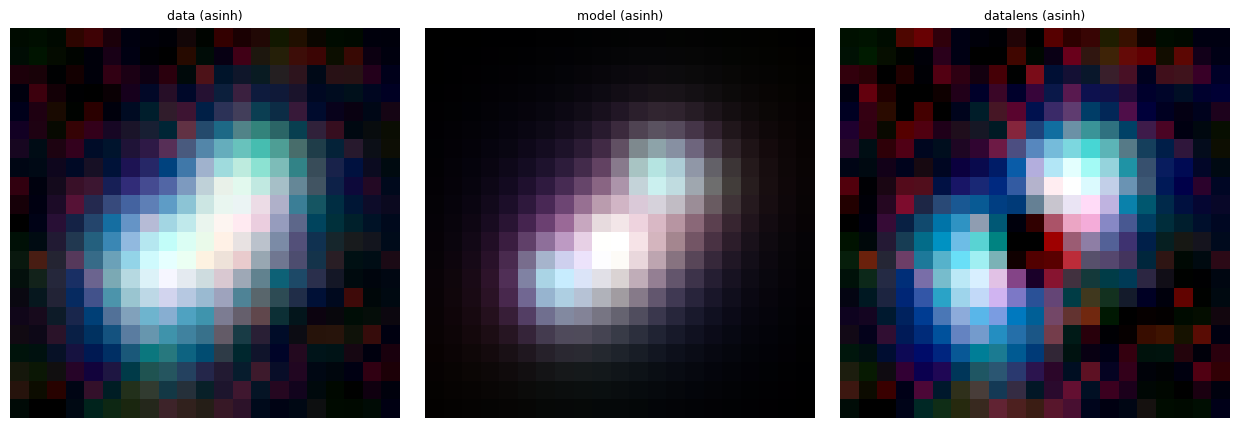

In [61]:
# ========== (可选) 生成并展示 RGB 合成 ==========
# 取消下面注释即可显示
show_rgb_gallery(
    band_data,
    components=('data','model','datalens','data_minus_model_minus_lens'),
    method='lupton',
    Q=8, stretch=0.1, minimum=0.0,
    mask_negative=True,
    per_band_scale={'z':0.85, 'g':1.5},
    
    save_prefix="grz_rgb"
)

show_rgb_gallery(
    band_data,
    components=('data','model','datalens'),
    method='asinh',
    perc_lo=0.3, perc_hi=99.7, alpha=3.5,
    mask_negative=True,
    save_prefix="grz_rgb_asinh"
)